In [1]:
import os
import sys
import cv2
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt

sys.path.append('/home/hyunjoon/github/tracking-pytorch/')

In [2]:
from pysot.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker
from pysot.utils.bbox import get_axis_aligned_bbox, IoU
from pysot.utils.model_load import load_pretrain
from toolkit.datasets import DatasetFactory

In [3]:
torch.set_num_threads(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
# fn_config = 'experiments/baseline/config.yaml'
# snapshot = 'experiments/baseline/snapshot/checkpoint_e99.pth'
fn_config = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/config.yaml'
snapshot = '/home/hyunjoon/github/tracking-pytorch/experiments/siamcar_mobilenetv2_2gpu/snapshot/checkpoint_e20.pth'

In [5]:
cfg.merge_from_file(fn_config)
cfg.TRACK.LR = 0.1
cfg.TRACK.WINDOW_INFLUENCE = 0.42

# create model
model = ModelBuilder()

# load model
model = load_pretrain(model, snapshot).cuda().eval()

# build tracker
tracker = build_tracker(model)

In [6]:
tracker.anchors_cwh.shape

torch.Size([1, 4, 25, 25])

In [7]:
# test image sequence
test_name = 'basketball'

# path_seq = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000009'
# fn_gt = '~/dataset_jinwook/got-10k/val/GOT-10k_Val_000009/groundtruth.txt'
path_seq = '/home/hyunjoon/dataset/vot2018/{}/'.format(test_name)
fn_gt = '/home/hyunjoon/dataset/vot2018/{}/groundtruth.txt'.format(test_name)

path_seq = os.path.expanduser(path_seq)
fn_gt = os.path.expanduser(fn_gt)

gt_seq = open(fn_gt, 'r').read().splitlines()
gt_seq = [np.fromstring(l, sep=',') for l in gt_seq]
gt_seq = np.stack(gt_seq, axis=0)

if gt_seq.shape[1] == 8:
    x0 = np.min(gt_seq[:, 0::2], axis=-1)
    y0 = np.min(gt_seq[:, 1::2], axis=-1)
    x1 = np.max(gt_seq[:, 0::2], axis=-1)
    y1 = np.max(gt_seq[:, 1::2], axis=-1)
    
    gt_seq = np.stack([x0, y0, x1-x0, y1-y0], axis=-1)

files_seq = [os.path.join(path_seq, '{:08d}.jpg'.format(i)) for i in range(1, len(gt_seq)+1)]

In [8]:
def _iou(lhs, rhs):
    d = np.minimum(lhs[2:]+lhs[:2], rhs[2:]+rhs[:2]) - np.maximum(lhs[:2], rhs[:2])
    d = np.maximum(d, 0.0)
    I = d[0] * d[1]
    A = lhs[2]*lhs[3] + rhs[2]*rhs[3]
    return I / (A - I)

In [ ]:
img = cv2.imread(files_seq[0])
tracker.init(img, gt_seq[0])

if not os.path.exists('./result_images/{}'.format(test_name)):
    os.makedirs('./result_images/{}'.format(test_name))

plt.figure(figsize=(12,12))

ft0 = None # template
ft1 = None
ix0 = -1
iy0 = -1
att_k = None

print('Tracking started, total {} frames.'.format(len(files_seq)))
for ii, fn in enumerate(files_seq[1:], 1):
    t_img = cv2.imread(fn)
    res = tracker.track(t_img)
    
    break
    rbb = np.array(res['bbox'])
    best_idx = res['best_idx']
#     best_score = res['score'][best_idx]
#     print(best_score)

#     output = res['output']
    gt_bb = gt_seq[ii]
    iou = _iou(rbb, gt_bb)
    
    break
    
#     if ii > 10:
#         break
    
    if iou < 0.3:
        print('Miss at frame {}'.format(ii))
        break

    plt.imshow(t_img[:, :, ::-1])
    rect = plt.Rectangle((rbb[0], rbb[1]),
                         rbb[2],
                         rbb[3], fill=False,
                         edgecolor=[1, 0, 0], linewidth=3.5)
    plt.gca().add_patch(rect)
    
    gtbb = gt_seq[ii]
    rect = plt.Rectangle((gtbb[0], gtbb[1]),
                         gtbb[2],
                         gtbb[3], fill=False,
                         edgecolor=[0, 1, 0], linewidth=2.5)
    plt.gca().add_patch(rect)
    plt.savefig('./result_images/{}/res_{:04d}.png'.format(test_name, ii))
    plt.clf()

Tracking started, total 725 frames.
> /home/hyunjoon/github/tracking-pytorch/pysot/models/model_builder.py(113)track()
    112         # [num_roi, ch, 7, 7]
--> 113         xf_rcnn = self.crop_align_feature(xf, anchor.view(1, -1, 4), (15, 15))
    114         xf_rcnn = self.rcnn_backbone(xf_rcnn)



ipdb>  anchor


tensor([[-20.8733, -49.0580,  20.8733,  49.0580],
        [-28.9953, -48.7729,  12.9953,  48.7729],
        [-12.1500, -50.8190,  28.1500,  50.8190],
        [-21.6821, -31.2278,  21.6821,  63.2278],
        [-20.8457, -73.1227,  20.8457,  25.1227],
        [-59.9760, -99.2615, -20.0240,   3.2615],
        [-68.5727,  14.2252, -27.4273, 113.7748],
        [-12.3412, -74.3412,  28.3412,  26.3412]], device='cuda:0',
       grad_fn=<IndexSelectBackward>)


ipdb>  n


> /home/hyunjoon/github/tracking-pytorch/pysot/models/model_builder.py(114)track()
    113         xf_rcnn = self.crop_align_feature(xf, anchor.view(1, -1, 4), (15, 15))
--> 114         xf_rcnn = self.rcnn_backbone(xf_rcnn)
    115 



ipdb>  n


> /home/hyunjoon/github/tracking-pytorch/pysot/models/model_builder.py(116)track()
    115 
--> 116         ctr_rcnn, iou_rcnn, loc_rcnn = self.rcnn_head(self.zf_rcnn, xf_rcnn)
    117 



ipdb>  xf_rcnn.shape


torch.Size([8, 640, 7, 7])


ipdb>  n


> /home/hyunjoon/github/tracking-pytorch/pysot/models/model_builder.py(119)track()
    118         return {
--> 119                 'ctr_rpn': ctr_rpn,
    120                 'asp_rpn': asp_rpn,



ipdb>  ctr_rcnn


tensor([[[[ -9.6323]]],


        [[[ -9.6559]]],


        [[[ -9.1978]]],


        [[[-10.5712]]],


        [[[ -8.6696]]],


        [[[ -9.6756]]],


        [[[ -8.1493]]],


        [[[ -8.9580]]]], device='cuda:0', grad_fn=<CudnnConvolutionBackward>)


ipdb>  iou_rcnn


tensor([[[[-7.2032]]],


        [[[-7.6253]]],


        [[[-6.9785]]],


        [[[-7.7973]]],


        [[[-6.7871]]],


        [[[-7.7847]]],


        [[[-7.2313]]],


        [[[-6.9210]]]], device='cuda:0', grad_fn=<CudnnConvolutionBackward>)


ipdb>  anchor_rcnn


*** NameError: name 'anchor_rcnn' is not defined


ipdb>  anchor


tensor([[-20.8733, -49.0580,  20.8733,  49.0580],
        [-28.9953, -48.7729,  12.9953,  48.7729],
        [-12.1500, -50.8190,  28.1500,  50.8190],
        [-21.6821, -31.2278,  21.6821,  63.2278],
        [-20.8457, -73.1227,  20.8457,  25.1227],
        [-59.9760, -99.2615, -20.0240,   3.2615],
        [-68.5727,  14.2252, -27.4273, 113.7748],
        [-12.3412, -74.3412,  28.3412,  26.3412]], device='cuda:0',
       grad_fn=<IndexSelectBackward>)


ipdb>  ancho


*** NameError: name 'ancho' is not defined


ipdb>  anchor


tensor([[-20.8733, -49.0580,  20.8733,  49.0580],
        [-28.9953, -48.7729,  12.9953,  48.7729],
        [-12.1500, -50.8190,  28.1500,  50.8190],
        [-21.6821, -31.2278,  21.6821,  63.2278],
        [-20.8457, -73.1227,  20.8457,  25.1227],
        [-59.9760, -99.2615, -20.0240,   3.2615],
        [-68.5727,  14.2252, -27.4273, 113.7748],
        [-12.3412, -74.3412,  28.3412,  26.3412]], device='cuda:0',
       grad_fn=<IndexSelectBackward>)


ipdb>  anchor.shape


torch.Size([8, 4])


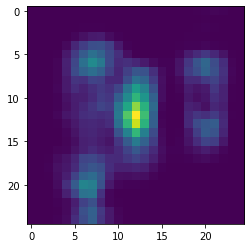

In [10]:
plt.imshow(res['ctr_rpn'].reshape(25, 25))

In [15]:
rbb

[277.5952288490204, 304.2026180843002, 45.0100000656312, 110.98000003745429]

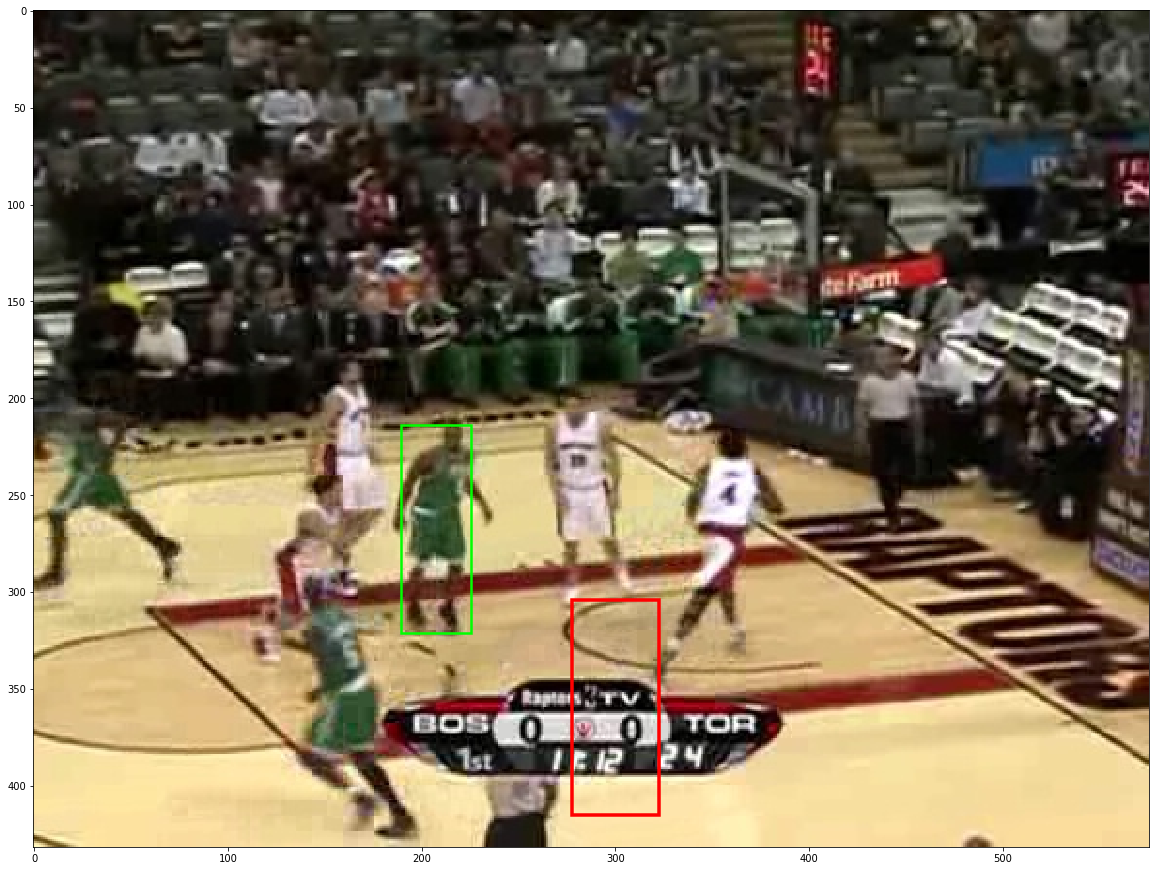

In [13]:
rbb = res['bbox']
plt.figure(figsize=(20,20))
plt.imshow(t_img[:, :, ::-1])
rect = plt.Rectangle((rbb[0], rbb[1]),
                     rbb[2],
                     rbb[3], fill=False,
                     edgecolor=[1, 0, 0], linewidth=3.5)
plt.gca().add_patch(rect)

gtbb = gt_seq[ii]
rect = plt.Rectangle((gtbb[0], gtbb[1]),
                     gtbb[2],
                     gtbb[3], fill=False,
                     edgecolor=[0, 1, 0], linewidth=2.5)
plt.gca().add_patch(rect)

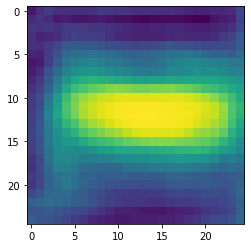

In [12]:
score = res['ctr_rpn'].reshape((25, 25))
plt.imshow(score)
plt.savefig('./result_images/{}/score_{:04d}.png'.format(test_name, ii))
# plt.close('all')

In [15]:
res['bbox']

[1124.1264709554084, 1100.5304223544738, 583.0244018391833, 274.61713380667726]

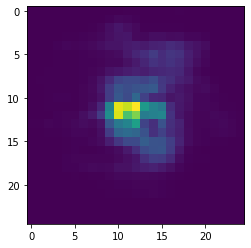

In [36]:
ctr = res['centerness'].reshape((25, 25))
plt.imshow(ctr)
# plt.savefig('./result_images/{}/pscore_{:04d}.png'.format(test_name, ii))